source: https://www.kaggle.com/trainorpj/tfp-logistic-regression

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

#tf.enable_eager_execution()
tfd = tfp.distributions

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

In [2]:
data = pd.read_csv("data/challenger_data.csv")
data.drop(24, axis=0, inplace=True)
data.dropna(inplace=True)
xs = data["Temperature"].values
ys = data["Damage Incident"].values
mean, std = xs.mean(), xs.std()
xs = ((xs - mean) / std).reshape(-1, 1)
ys = ys.astype(np.int32)

n_observations = len(xs)
lr = LogisticRegression(random_state=0)
lr.fit(xs.reshape(-1, 1), ys)
w, b = lr.coef_.item(), lr.intercept_.item()
print("w: ", w, "b: ", b)

w:  -1.1210259129228146 b:  -0.9964903986472655


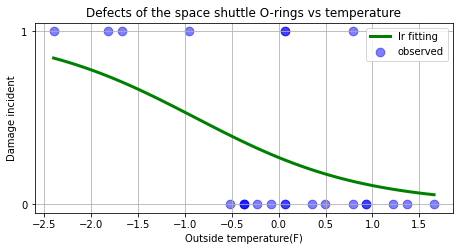

In [3]:
_xs = np.linspace(xs.min(), xs.max(), 50)
_ys = lr.predict_proba(_xs.reshape(-1, 1))[:, 1]

plt.figure(figsize=(7.5, 3.5))
plt.scatter(xs, ys, s=75, color="b", alpha=0.5, label="observed")
plt.plot(_xs, _ys, lw=3, color="green", label="lr fitting")
plt.yticks([0, 1])
plt.ylabel("Damage incident")
plt.xlabel("Outside temperature(F)")
plt.legend(loc="upper right")
plt.title("Defects of the space shuttle O-rings vs temperature")
plt.grid()

In [4]:
# placeholder variables
x = tf.placeholder(shape=[None, 1], dtype=tf.float32)
y = tf.placeholder(shape=[None, 1], dtype=tf.int32)

# flipout layer, which will yield distributions on our weights
# in this case, only one weight and a bias term, each with normal priors
layer = tfp.layers.DenseFlipout(1, 
                                activation=None,
                                kernel_posterior_fn=tfp.layers.default_mean_field_normal_fn(),
                                bias_posterior_fn=tfp.layers.default_mean_field_normal_fn())

# make a prediction
logits = layer(x)
# those predictions are parameters for bernoulli distributions 
labels_dist = tfd.Bernoulli(logits=logits)

# use evidence-lower bound (ELBO) as the loss
neg_log_likelihood = -tf.reduce_mean(labels_dist.log_prob(y))
kl = sum(layer.losses) / n_observations
elbo_loss = neg_log_likelihood + kl

# make predictions, and check accuracy
predictions = tf.cast(logits > 0, dtype=tf.int32)
correct_predictions = tf.equal(predictions, y)
accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))

# minimize ELBO
optimizer = tf.train.AdamOptimizer(learning_rate=0.01)
train_op = optimizer.minimize(elbo_loss)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [5]:
n_steps = 1300
n_posterior_samples = 125

history_loss = []
history_acc = []

candidate_ws = []
candidate_bs = []

init_op = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init_op)
    
    # run training loop
    print("Start training...")
    for step in range(n_steps):
        # feed in training data
        feed_dict = {x: xs.reshape(-1, 1), y: ys.reshape(-1, 1)}
        
        # execute the graph 
        _ = sess.run(train_op, feed_dict=feed_dict)
        
        # determine loss and accuracy
        loss_value, acc_value = sess.run([elbo_loss, accuracy],feed_dict=feed_dict)
        
        if ((step + 1) % 100) == 0:
            print(f"{'-'*50} step {step + 1}")
            print(f"Loss {loss_value:.3f}, Accuracy: {acc_value:.3f}")
        
        # record loss and accuracy
        history_loss.append(loss_value)
        history_acc.append(acc_value)
    
    print("Done training!\n")
    print(f"Taking {n_posterior_samples} samples from posterior distributions on weights\n")
    
    w_draw = layer.kernel_posterior.sample(seed=27)
    b_draw = layer.bias_posterior.sample(seed=27)
    
    for mc in range(n_posterior_samples):
        w_, b_ = sess.run([w_draw, b_draw])
        candidate_ws.append(w_)
        candidate_bs.append(b_)
        
    print("Sampling complete. Samples are stored in numpy arrays:")
    print(f"  weight: candidate_ws")
    print(f"    bias: candidate_bs")
        
candidate_ws = np.array(candidate_ws).reshape(-1, 1).astype(np.float32)
candidate_bs = np.array(candidate_bs).astype(np.float32)

Start training...
-------------------------------------------------- step 100
Loss 0.554, Accuracy: 0.826
-------------------------------------------------- step 200
Loss 0.526, Accuracy: 0.826
-------------------------------------------------- step 300
Loss 0.500, Accuracy: 0.870
-------------------------------------------------- step 400
Loss 0.522, Accuracy: 0.826
-------------------------------------------------- step 500
Loss 0.496, Accuracy: 0.870
-------------------------------------------------- step 600
Loss 0.457, Accuracy: 0.870
-------------------------------------------------- step 700
Loss 0.510, Accuracy: 0.870
-------------------------------------------------- step 800
Loss 0.494, Accuracy: 0.870
-------------------------------------------------- step 900
Loss 0.479, Accuracy: 0.870
-------------------------------------------------- step 1000
Loss 0.537, Accuracy: 0.826
-------------------------------------------------- step 1100
Loss 0.576, Accuracy: 0.783
------------

Text(0.5, 1.0, 'Accurate')

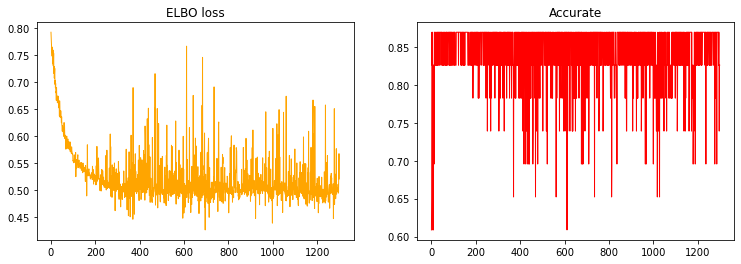

In [6]:
plt.figure(figsize=(12.5, 4))
plt.subplot(121)
plt.plot(history_loss, color="orange", lw=1)
plt.title("ELBO loss")

plt.subplot(122)
plt.plot(history_acc, color="red", lw=1)
plt.title("Accurate")

Text(0.5, 1.0, '$b$ posterior')

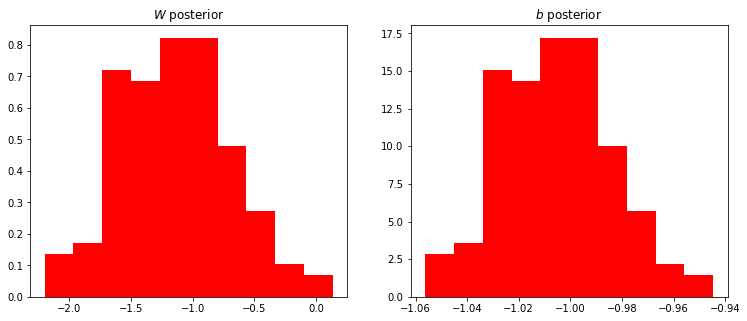

In [7]:
plt.figure(figsize=(12.5, 5))
plt.subplot(121)
plt.hist(candidate_ws, histtype="stepfilled", density=True, color="red")
plt.title("$W$ posterior")

plt.subplot(122)
plt.hist(candidate_bs, histtype="stepfilled", density=True, color="red")
plt.title("$b$ posterior")

In [8]:
probs = 1 / (1 + np.exp(-candidate_ws @ _xs.reshape(1, -1) + candidate_bs))
mean_prob = probs.mean(axis=0)
high, low = np.quantile(probs, [0.975, 0.025], axis=0)

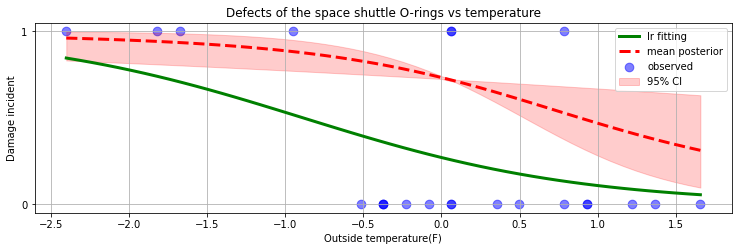

In [9]:
plt.figure(figsize=(12.5, 3.5))
plt.scatter(xs, ys, s=75, color="b", alpha=0.5, label="observed")
plt.plot(_xs, _ys, lw=3, color="green", label="lr fitting")
plt.plot(_xs, mean_prob, lw=3, linestyle="--", color="red", label="mean posterior")
plt.fill_between(_xs, high, low, alpha=0.2, color="red", label="95% CI")
plt.yticks([0, 1])
plt.ylabel("Damage incident")
plt.xlabel("Outside temperature(F)")
plt.legend(loc="upper right")
plt.title("Defects of the space shuttle O-rings vs temperature")
plt.grid()